In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pstq8sMQx5LLf0XseHSw")
project = rf.workspace("vision-1t8xz").project("modanet-maskrcnn-ivbxz")
version = project.version(1)
dataset = version.download("coco")
                

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import os

# Path to your downloaded dataset
dataset_path = "/kaggle/working/Modanet-MaskRCNN-1/"

# List all JSON files recursively
json_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".json"):
            json_files.append(os.path.join(root, file))

print("Found JSON annotation files:")
for f in json_files:
    print(f)



In [2]:
import json
from pycocotools.coco import COCO


clean_file = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations.coco.json"

# Load JSON directly
with open(clean_file, "r") as f:
    data = json.load(f)

print("Categories in cleaned JSON:")
for cat in data["categories"]:
    print(f"ID {cat['id']}: {cat['name']}")


Categories in cleaned JSON:
ID 0: fashion
ID 1: bag
ID 2: belt
ID 3: boots
ID 4: dress
ID 5: footwear
ID 6: headwear
ID 7: outer
ID 8: pants
ID 9: scarf-tie
ID 10: shorts
ID 11: skirt
ID 12: sunglasses
ID 13: top


In [3]:
from collections import defaultdict
# Load COCO annotations
coco = COCO('/kaggle/working/Modanet-MaskRCNN-1/train/_annotations.coco.json')

# Get all category info
cats = coco.loadCats(coco.getCatIds())

class_img_count = defaultdict(int)
for cat in cats:
    cat_id = cat['id']
    img_ids = coco.getImgIds(catIds=[cat_id])
    class_img_count[cat['name']] = len(img_ids)

# Sort by count (ascending)
sorted_counts = sorted(class_img_count.items(), key=lambda x: x[1])

# Print sorted list
print("Classes sorted by number of images (least to most):")
for class_name, count in sorted_counts:
    print(f"{class_name}: {count} images")

# Print the least populated class(es)
min_count = sorted_counts[0][1]
least_classes = [name for name, count in sorted_counts if count == min_count]
print("\nLeast populated class(es):", least_classes, "with", min_count, "images")


loading annotations into memory...
Done (t=3.74s)
creating index...
index created!
Classes sorted by number of images (least to most):
fashion: 0 images
scarf-tie: 5018 images
headwear: 5446 images
shorts: 7028 images
boots: 7080 images
sunglasses: 8784 images
skirt: 13569 images
belt: 14288 images
dress: 14416 images
bag: 20560 images
pants: 23003 images
outer: 23676 images
top: 34665 images
footwear: 39199 images

Least populated class(es): ['fashion'] with 0 images


In [4]:
import json

ann_file = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations.coco.json"
out_file = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations_renamed_background.coco.json" # New output file name

with open(ann_file, "r") as f:
    coco_json = json.load(f)


found_fashion_and_renamed = False
for cat in coco_json["categories"]:
    if cat["name"] == "fashion":
        # Check if it's indeed ID 0 as you mentioned
        if cat["id"] == 0:
            cat["name"] = "background"
            print(f"Renamed category ID {cat['id']} from 'fashion' to 'background'.")
            found_fashion_and_renamed = True
            break #

if not found_fashion_and_renamed:
    print("Warning: 'fashion' category (ID 0) not found or its ID was not 0. No rename performed.")

with open(out_file, "w") as f:
    json.dump(coco_json, f)

print(f"Modified JSON with 'fashion' renamed to 'background' saved to: {out_file}")

print("\nCategories in the new cleaned JSON:")
for cat in coco_json["categories"]:
    print(f"ID {cat['id']}: {cat['name']}")


Renamed category ID 0 from 'fashion' to 'background'.
Modified JSON with 'fashion' renamed to 'background' saved to: /kaggle/working/Modanet-MaskRCNN-1/train/_annotations_renamed_background.coco.json

Categories in the new cleaned JSON:
ID 0: background
ID 1: bag
ID 2: belt
ID 3: boots
ID 4: dress
ID 5: footwear
ID 6: headwear
ID 7: outer
ID 8: pants
ID 9: scarf-tie
ID 10: shorts
ID 11: skirt
ID 12: sunglasses
ID 13: top


In [ ]:
from pycocotools.coco import COCO
from collections import defaultdict

json_path = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations_renamed_background.coco.json"
coco = COCO(json_path)

cats = coco.loadCats(coco.getCatIds())

class_img_count = defaultdict(int)
for cat in cats:
    cat_id = cat['id']
    img_ids = coco.getImgIds(catIds=[cat_id])
    class_img_count[cat['name']] = len(img_ids)

sorted_counts = sorted(class_img_count.items(), key=lambda x: x[1])

print("sorted classes")
for class_name, count in sorted_counts:
    print(f"{class_name}: {count} images")

min_count = sorted_counts[0][1]
least_classes = [name for name, count in sorted_counts if count == min_count]
print("from Least :", least_classes, "with", min_count, "images")


loading annotations into memory...
Done (t=3.84s)
creating index...
index created!


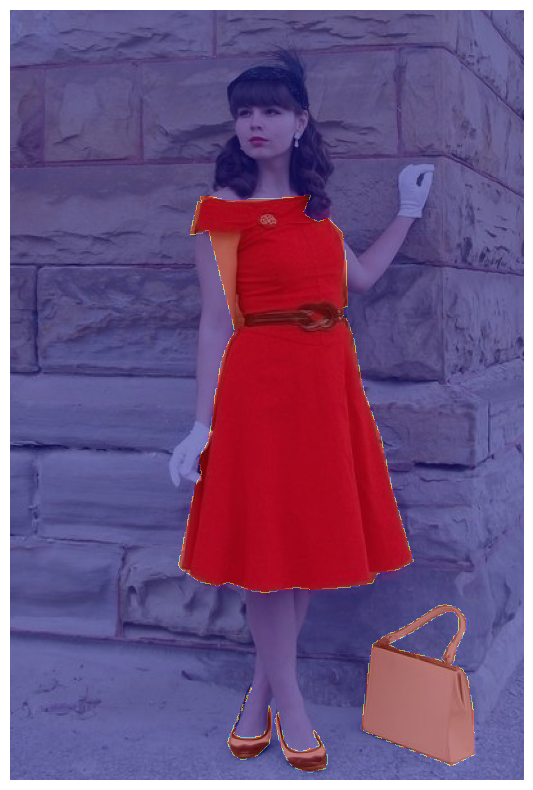

In [5]:
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

ann_file = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations_renamed_background.coco.json"
img_dir = "/kaggle/working/Modanet-MaskRCNN-1/train"

coco = COCO(ann_file)

img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(img_dir, img_info['file_name'])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

for ann in anns:
    if 'segmentation' in ann:
        segm = ann['segmentation']
        if isinstance(segm, list):
            
            for poly in segm:
                poly = np.array(poly).reshape((-1, 2))
                cv2.fillPoly(mask, [poly.astype(np.int32)], 1)
        else:
            
            rle = maskUtils.frPyObjects(segm, img_info['height'], img_info['width'])
            mask += maskUtils.decode(rle)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap='jet')  
plt.axis('off')
plt.show()


In [6]:
import os
import random
import cv2
import numpy as np
import torch
from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils


RARE_CLASSES = ["scarf-tie", "headwear", "shorts", "boots", "sunglasses"]

In [7]:
RARE_CLASSES = ["scarf-tie", "headwear", "shorts", "boots", "sunglasses"]
class CocoSegDataset(Dataset):
    def __init__(self, ann_file, img_dir,
                 base_transform,
                 rare_transform=None,
                 rare_classes=None,
                 rare_aug_prob=0.3,
                 default_size=(128, 128)):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.img_ids = self.coco.getImgIds()

        self.base_transform = base_transform
        self.rare_transform = rare_transform
        self.rare_classes = rare_classes or []
        self.rare_aug_prob = rare_aug_prob
        self.default_size = default_size

        # category mappings
        self.cat_map = {c['id']: c['name'] for c in self.coco.loadCats(self.coco.getCatIds())}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            img = np.zeros((self.default_size[0], self.default_size[1], 3), dtype=np.uint8)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]

        # Initialize mask
        mask = np.zeros((height, width), dtype=np.uint8)
        classes_in_img = set()

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id == 0:
                continue

            if isinstance(ann['segmentation'], list):
                rles = maskUtils.frPyObjects(ann['segmentation'], height, width)
            else:
                rles = ann['segmentation']

            decoded_mask = maskUtils.decode(rles)
            if decoded_mask.ndim == 3:
                decoded_mask = np.max(decoded_mask, axis=-1)

            mask = np.where((decoded_mask > 0) & (cat_id > mask), cat_id, mask)
            classes_in_img.add(self.cat_map[cat_id])

        # Apply rare augmentation probabilistically
        if self.rare_transform and any(c in self.rare_classes for c in classes_in_img):
            if random.random() < self.rare_aug_prob:
                transformed = self.rare_transform(image=img, mask=mask)
                img, mask = transformed['image'], transformed['mask']

        # Always apply base transform last
        transformed = self.base_transform(image=img, mask=mask)
        img, mask = transformed['image'], transformed['mask']

        # Convert to tensors
        img = torch.from_numpy(img.transpose(2, 0, 1)).float()  # HWC → CHW
        mask = torch.from_numpy(mask).long()

        return img, mask

In [8]:
train_base_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.CLAHE(p=0.2),
    A.GridDistortion(p=0.2),
    A.ElasticTransform(p=0.2),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.ImageCompression(quality_lower=40, quality_upper=90, p=0.3),
    A.Normalize(),
])

rare_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.Normalize(),
])

preprocess_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_218/3080146442.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipykernel_218/3080146442.py:15: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=40, quality_upper=90, p=0.3),


In [9]:
ann_file = "/kaggle/working/Modanet-MaskRCNN-1/train/_annotations_renamed_background.coco.json"
img_dir = "/kaggle/working/Modanet-MaskRCNN-1/train"

full_dataset_train = CocoSegDataset(
    ann_file=ann_file,
    img_dir=img_dir,
    base_transform=train_base_transform,
    rare_transform=rare_transform,
    rare_classes=RARE_CLASSES,
    rare_aug_prob=0.3
)

full_dataset_val = CocoSegDataset(
    ann_file=ann_file,
    img_dir=img_dir,
    base_transform=preprocess_transform
)

full_dataset_test = CocoSegDataset(
    ann_file=ann_file,
    img_dir=img_dir,
    base_transform=preprocess_transform
)


loading annotations into memory...
Done (t=3.90s)
creating index...
index created!
loading annotations into memory...
Done (t=4.48s)
creating index...
index created!
loading annotations into memory...
Done (t=2.88s)
creating index...
index created!


In [10]:
total_len = len(full_dataset_train)
train_len = int(0.6 * total_len)
val_len = int(0.25 * total_len)
test_len = total_len - train_len - val_len

g = torch.Generator().manual_seed(42)
indices = torch.randperm(total_len, generator=g)

train_indices = indices[:train_len]
val_indices = indices[train_len:train_len + val_len]
test_indices = indices[train_len + val_len:]

train_dataset = Subset(full_dataset_train, train_indices)
val_dataset = Subset(full_dataset_val, val_indices)
test_dataset = Subset(full_dataset_test, test_indices)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 31335, Val: 13056, Test: 7834


In [11]:
batch_size = 16
num_workers = 4
pin_memory = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

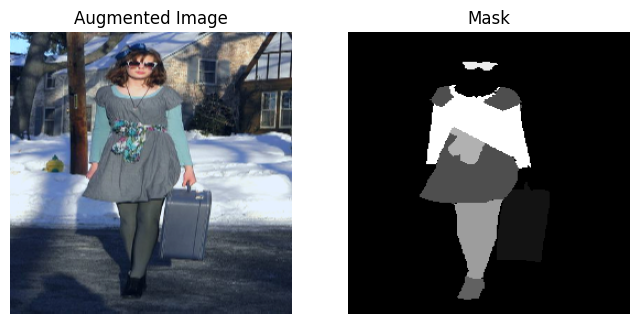

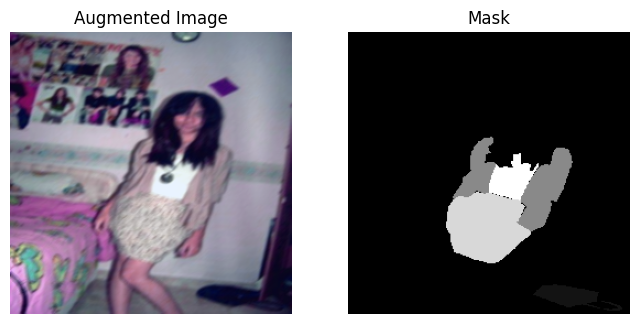

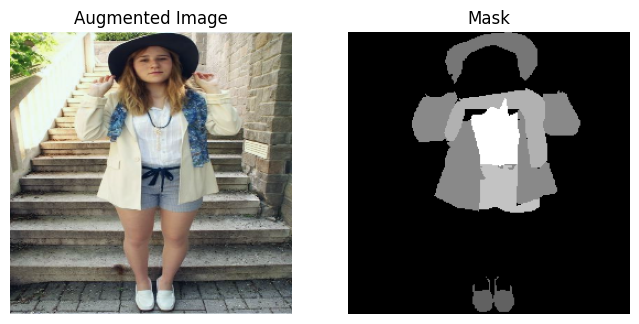

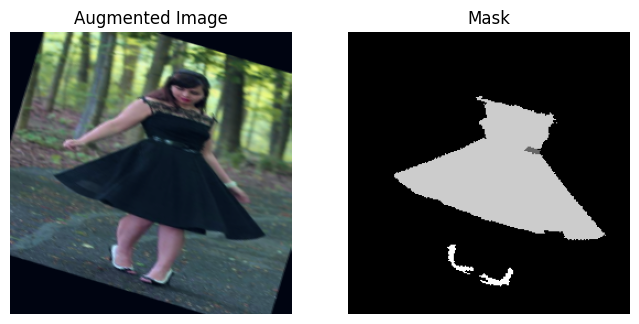

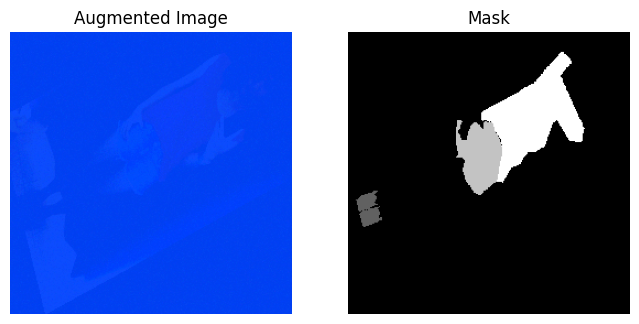

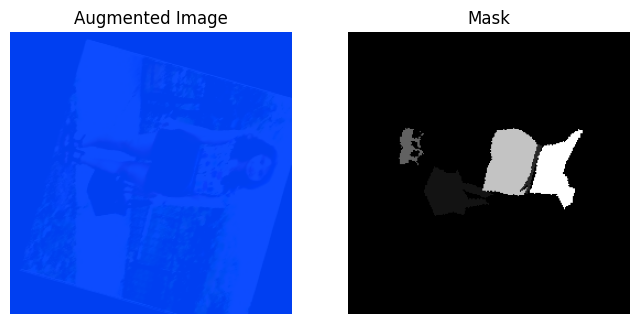

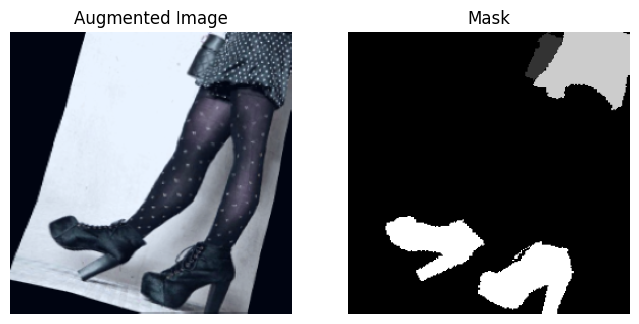

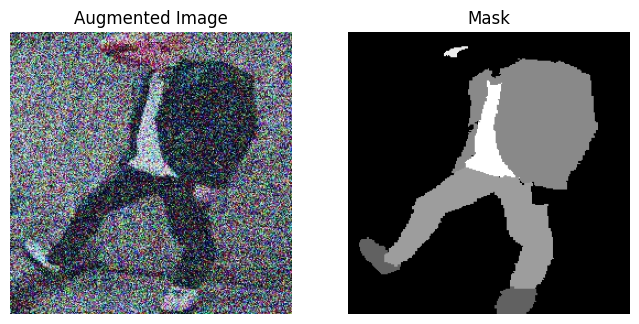

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_batch(loader, num_samples=8):
    # take one batch
    images, masks = next(iter(loader))

    # move to CPU if on GPU
    images = images.cpu()
    masks = masks.cpu()

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize to [0,1]

        mask = masks[i].squeeze().numpy()

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title("Augmented Image")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()


show_batch(train_loader, num_samples=8)


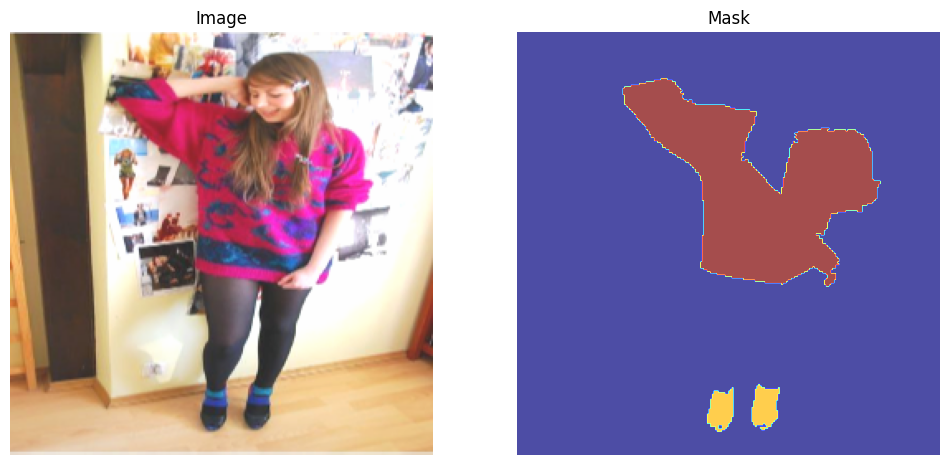

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
imgs, masks = next(iter(train_loader))

# Select the first image in the batch
img = imgs[0].permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
mask = masks[0].cpu().numpy()

# Denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img = std * img + mean  # undo normalization
img = np.clip(img * 255, 0, 255).astype(np.uint8)  # convert to 0-255

# Plot image and mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='jet', alpha=0.7)
plt.title("Mask")
plt.axis("off")

plt.show()


In [14]:
from collections import defaultdict

def count_augmented_classes(subset):
    class_counts = defaultdict(int)
    dataset = subset.dataset if hasattr(subset, 'dataset') else subset
    indices = getattr(subset, 'indices', range(len(dataset)))

    for idx in indices:
        img_id = dataset.img_ids[idx]
        ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
        anns = dataset.coco.loadAnns(ann_ids)

        for ann in anns:
            cls = dataset.cat_map[ann['category_id']]
            class_counts[cls] += 1
            if cls in dataset.rare_classes:  
                class_counts[cls] += 1

    return class_counts


In [15]:
train_aug_counts = count_augmented_classes(train_dataset)
print(train_aug_counts)


defaultdict(<class 'int'>, {'belt': 8651, 'top': 21748, 'shorts': 8456, 'footwear': 50934, 'dress': 8759, 'bag': 12447, 'skirt': 8187, 'outer': 15143, 'pants': 13939, 'scarf-tie': 6088, 'boots': 17970, 'sunglasses': 10450, 'headwear': 6534})


In [16]:

val_aug_counts   = count_augmented_classes(val_dataset)
print(val_aug_counts)
test_aug_counts  = count_augmented_classes(test_dataset)
print(test_aug_counts )

defaultdict(<class 'int'>, {'headwear': 1358, 'pants': 5751, 'top': 9079, 'footwear': 21290, 'outer': 6238, 'dress': 3666, 'scarf-tie': 1289, 'bag': 5264, 'shorts': 1768, 'boots': 3851, 'skirt': 3394, 'belt': 3588, 'sunglasses': 2240})
defaultdict(<class 'int'>, {'belt': 2111, 'top': 5447, 'shorts': 1076, 'headwear': 823, 'footwear': 12548, 'pants': 3471, 'outer': 3812, 'scarf-tie': 781, 'bag': 3155, 'dress': 2157, 'boots': 2326, 'skirt': 2068, 'sunglasses': 1324})


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split


In [18]:

import torch
import segmentation_models_pytorch as smp

num_classes = 14

# Define U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # encoder backbone
    encoder_weights="imagenet",     # pretrained on ImageNet
    in_channels=3,                  # RGB images
    classes=num_classes             # output channels = num classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [19]:
criterion = nn.CrossEntropyLoss()  # masks are integer class IDs
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [20]:
import torch
from tqdm import tqdm

# ----------------------------
# Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = torch.cuda.amp.GradScaler()
num_epochs = 10
patience = 3  
bad_epochs = 0
best_val_loss = float('inf')


for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch")

    for i, (imgs, masks) in enumerate(loop, 1):
        imgs = imgs.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)  # shape: B x C x H x W
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        loop.set_postfix(loss=train_loss / i, device=str(device))

    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", unit="batch")
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(loop_val, 1):
            imgs = imgs.to(device, dtype=torch.float)
            masks = masks.to(device, dtype=torch.long)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, masks)
            val_loss += loss.item()
            loop_val.set_postfix(loss=val_loss / i, device=str(device))

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Scheduler Step ----
    # If using ReduceLROnPlateau, step with validation loss
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # ---- Early Stopping & Checkpoint ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        bad_epochs += 1
        print(f"Validation loss did not improve for {bad_epochs} epoch(s).")
        if bad_epochs >= patience:
            print("Early stopping triggered!")
            break


/tmp/ipykernel_218/647630577.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/1959 [00:00<?, ?batch/s]/tmp/ipykernel_218/647630577.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Val]:   0%|          | 0/816 [00:00<?, ?batch/s]/tmp/ipykernel_218/647630577.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Val]: 100%|██████████| 816/816 [00:55<00:00, 14.75batch/s, device=cuda, loss=0.256]


Epoch 1/10 | Train Loss: 0.5585 | Val Loss: 0.2557


Epoch 2/10 [Val]: 100%|██████████| 816/816 [00:55<00:00, 14.78batch/s, device=cuda, loss=0.215]


Epoch 2/10 | Train Loss: 0.3376 | Val Loss: 0.2150


Epoch 3/10 [Val]: 100%|██████████| 816/816 [00:53<00:00, 15.21batch/s, device=cuda, loss=0.204]


Epoch 3/10 | Train Loss: 0.3100 | Val Loss: 0.2036


Epoch 4/10 [Val]: 100%|██████████| 816/816 [00:55<00:00, 14.82batch/s, device=cuda, loss=0.184]


Epoch 4/10 | Train Loss: 0.2803 | Val Loss: 0.1840


Epoch 5/10 [Val]: 100%|██████████| 816/816 [00:55<00:00, 14.76batch/s, device=cuda, loss=0.181]


Epoch 5/10 | Train Loss: 0.2680 | Val Loss: 0.1814


Epoch 6/10 [Val]: 100%|██████████| 816/816 [00:55<00:00, 14.70batch/s, device=cuda, loss=0.174]


Epoch 6/10 | Train Loss: 0.2608 | Val Loss: 0.1736


Epoch 7/10 [Val]: 100%|██████████| 816/816 [00:53<00:00, 15.19batch/s, device=cuda, loss=0.167]


Epoch 7/10 | Train Loss: 0.2468 | Val Loss: 0.1672


Epoch 8/10 [Val]: 100%|██████████| 816/816 [00:53<00:00, 15.12batch/s, device=cuda, loss=0.165]


Epoch 8/10 | Train Loss: 0.2403 | Val Loss: 0.1649


Epoch 9/10 [Val]: 100%|██████████| 816/816 [00:54<00:00, 15.06batch/s, device=cuda, loss=0.163]


Epoch 9/10 | Train Loss: 0.2369 | Val Loss: 0.1628


Epoch 10/10 [Val]: 100%|██████████| 816/816 [00:53<00:00, 15.23batch/s, device=cuda, loss=0.16] 


Epoch 10/10 | Train Loss: 0.2298 | Val Loss: 0.1599


In [21]:
import torch, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import IPython.display as display


def clear_memory():
    """Force clear GPU + CPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 13
class_names = [
     "bag", "belt", "boots", "dress", "footwear",
    "headwear", "outer", "pants", "scarf-tie", "shorts",
    "skirt", "sunglasses", "top"
]

conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)

model.to(device)
model.eval()


batch_counter = 0

with torch.no_grad():
    loop = tqdm(test_loader, desc="Testing", unit="batch")
    for imgs, masks in loop:
        imgs = imgs.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.long)

        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

        # Flatten predictions & labels
        preds_np = preds.cpu().numpy().ravel()
        masks_np = masks.cpu().numpy().ravel()

        # Update confusion matrix
        conf_mat += confusion_matrix(masks_np, preds_np, labels=range(num_classes))

        # Free memory
        del preds, outputs, imgs, masks, preds_np, masks_np

        batch_counter += 1
        if batch_counter % 30 == 0:
            clear_memory()
            loop.set_postfix_str(f"Memory cleaned at batch {batch_counter}")


clear_memory()


precision = np.diag(conf_mat) / (conf_mat.sum(axis=0) + 1e-8)
recall    = np.diag(conf_mat) / (conf_mat.sum(axis=1) + 1e-8)
f1        = 2 * precision * recall / (precision + recall + 1e-8)
iou       = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat) + 1e-8)
support   = conf_mat.sum(axis=1)


results = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "IoU": iou,
    "Support": support
})

macro_avg = results[["Precision", "Recall", "F1-Score", "IoU"]].mean().to_dict()
macro_row = pd.DataFrame([{
    "Class": "Macro Avg",
    **macro_avg,
    "Support": support.sum()
}])

results = pd.concat([results, macro_row], ignore_index=True)


display.display(results.round(4))


Testing:   0%|          | 0/490 [00:00<?, ?batch/s]/tmp/ipykernel_218/1663335746.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing:   0%|          | 1/490 [00:00<07:45,  1.05batch/s]/tmp/ipykernel_218/1663335746.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing:   0%|          | 2/490 [00:01<04:34,  1.77batch/s]/tmp/ipykernel_218/1663335746.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing:   1%|          | 3/490 [00:01<03:13,  2.52batch/s]/tmp/ipykernel_218/1663335746.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast

Class  Precision  Recall  F1-Score     IoU    Support
0          bag     0.9840  0.9904    0.9872  0.9747  425867341
1         belt     0.7936  0.7046    0.7465  0.5955    4586983
2        boots     0.3816  0.0263    0.0492  0.0252     239463
3        dress     0.7216  0.5762    0.6408  0.4714    1632219
4     footwear     0.8004  0.8226    0.8114  0.6826   13535347
5     headwear     0.7045  0.7058    0.7051  0.5446    3454322
6        outer     0.8262  0.2844    0.4232  0.2684     633474
7        pants     0.8109  0.8090    0.8100  0.6807   16125233
8    scarf-tie     0.8709  0.8743    0.8726  0.7740   13105055
9       shorts     0.0000  0.0000    0.0000  0.0000    1164037
10       skirt     0.8117  0.7585    0.7842  0.6450    1836099
11  sunglasses     0.8145  0.8002    0.8073  0.6769    8755341
12         top     0.9223  0.0406    0.0778  0.0404     245923
13   Macro Avg     0.7263  0.5687    0.5935  0.4907  491180837

/tmp/ipykernel_218/1453587696.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


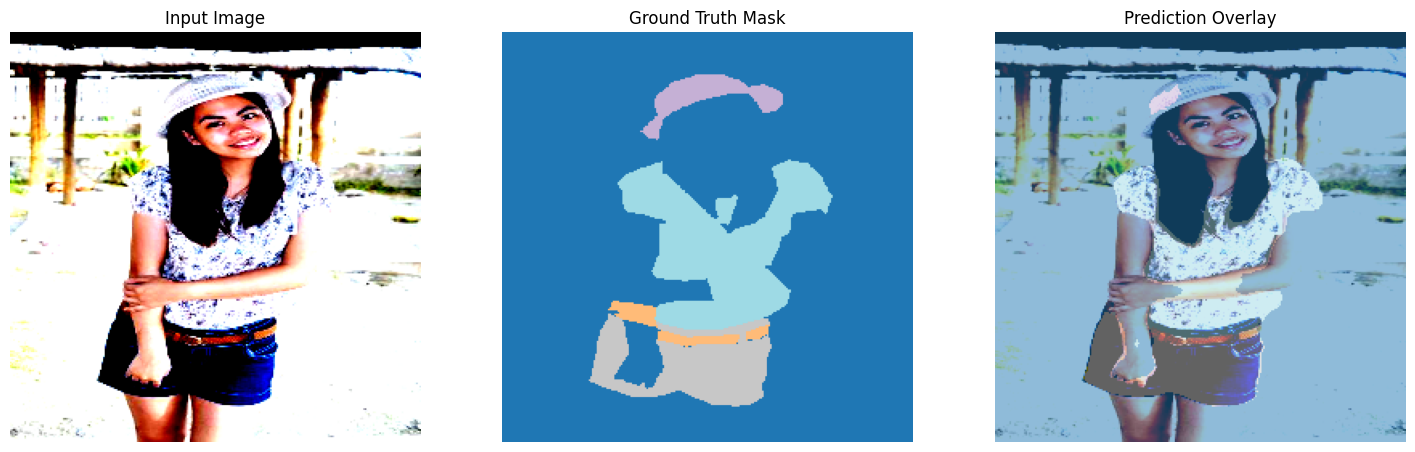

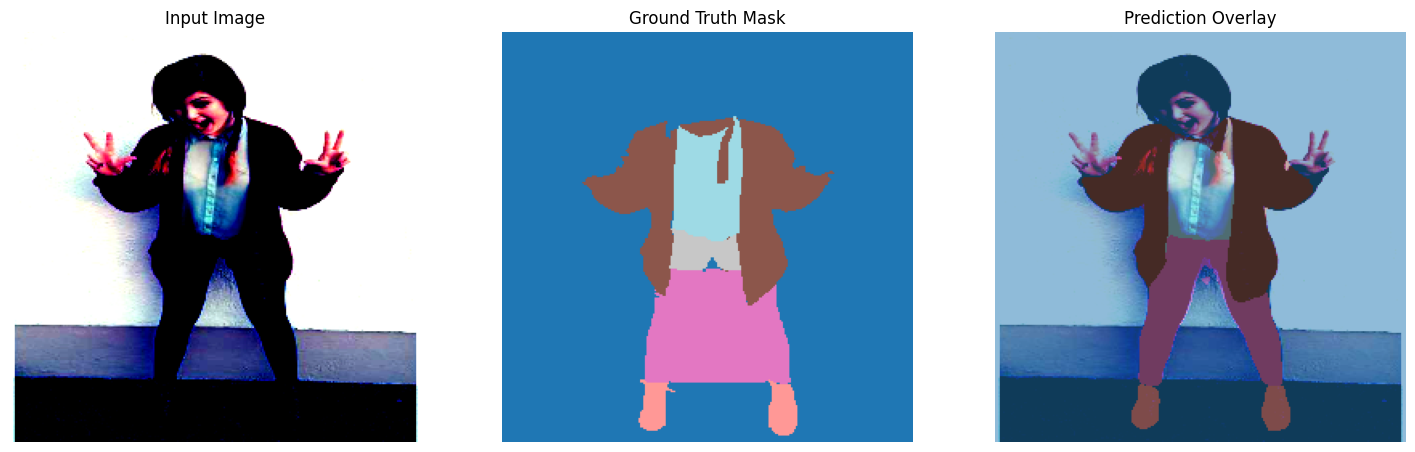

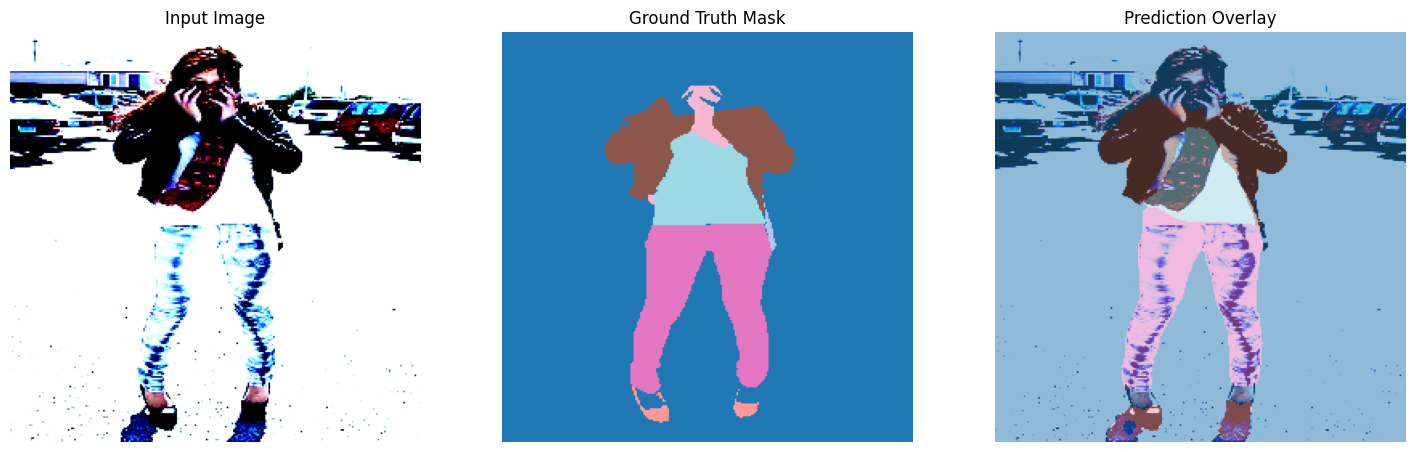

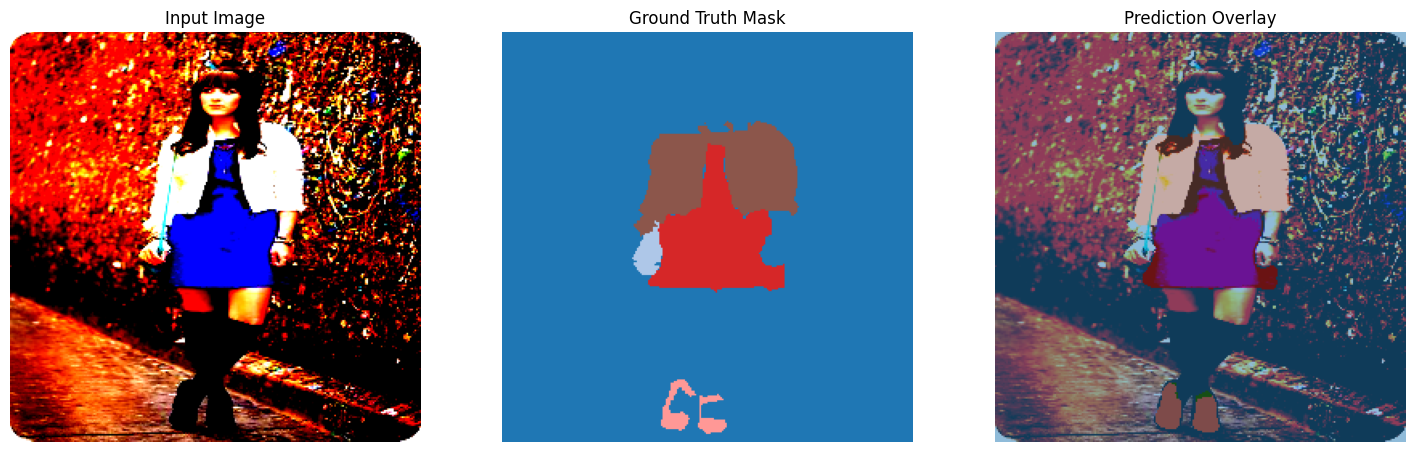

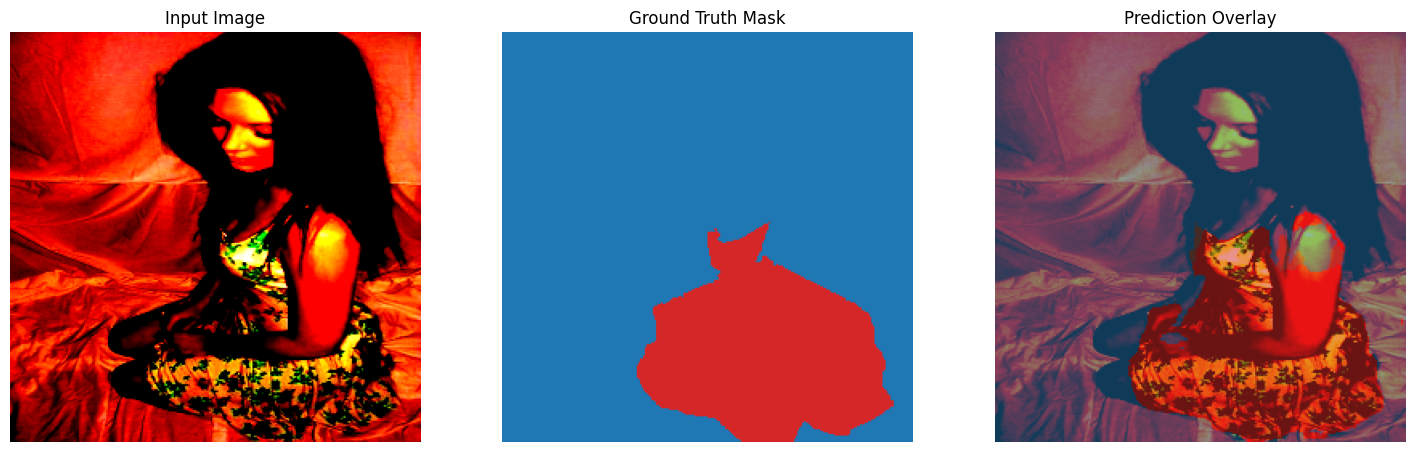

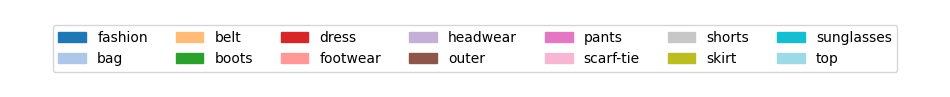

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# =============================
# 1. Generate Distinct Colors
# =============================
def generate_colors(num_classes):
    cmap = plt.get_cmap("tab20", num_classes)
    return (cmap(np.arange(num_classes))[:, :3] * 255).astype(np.uint8)

# =============================
# 2. Decode mask into color map
# =============================
def decode_segmap(mask, class_colors):
    return class_colors[mask]

# =============================
# 3. Show predictions
# =============================
def show_predictions(model, test_loader, class_names, num_samples=3, device="cuda"):
    model.eval()

    imgs, masks = next(iter(test_loader))  # one batch
    imgs, masks = imgs.to(device), masks.to(device)

    num_classes = len(class_names)
    class_colors = generate_colors(num_classes)

    with torch.no_grad(), torch.cuda.amp.autocast():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(min(num_samples, imgs.size(0))):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        mask_true = decode_segmap(masks[i].cpu().numpy(), class_colors)
        mask_pred = decode_segmap(preds[i].cpu().numpy(), class_colors)

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[0].axis("off")

        axs[1].imshow(mask_true)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        axs[2].imshow(img)
        axs[2].imshow(mask_pred, alpha=0.5)
        axs[2].set_title("Prediction Overlay")
        axs[2].axis("off")

        plt.show()

    # =============================
    # 4. Legend (category names)
    # =============================
    legend_colors = [tuple(c/255.0 for c in class_colors[i]) for i in range(num_classes)]
    fig, ax = plt.subplots(figsize=(12, 1))
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[i]) for i in range(num_classes)]
    ax.legend(handles, class_names, loc="center", ncol=min(num_classes, 7))
    ax.axis("off")
    plt.show()


# =============================
# Example usage
# =============================

class_names = [
    "fashion", "bag", "belt", "boots", "dress", "footwear", "headwear",
    "outer", "pants", "scarf-tie", "shorts", "skirt", "sunglasses", "top"
]

show_predictions(model, test_loader, class_names=class_names, num_samples=5, device=device)
